In [1]:
suppressMessages(library(ArchR))
ss <- function(x, pattern, slot = 1, ...) { sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)
suppressMessages(library(Seurat))
suppressMessages(library(SingleCellExperiment))

In [2]:
##################################
### set Arrow File parameters ####
addArchRThreads(threads = 12)

##################################
### load rheMac10 ArchR genome ###
GENOMEDIR='/home/bnphan/resources/genomes/rheMac10'
load(file.path(GENOMEDIR,'rheMac10_liftoff_GRCh38.p13_ArchR_annotations.rda'))

Setting default number of Parallel threads to 12.



In [3]:
PROJDIR='../../../data/tidy_data/ArchRProjects'
ARCHDIR=file.path(PROJDIR,'ArchR_Multiome_DLPFC_neuron')
proj = loadArchRProject(ARCHDIR)

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b5aaea98e-Date-2021-04-22_Time-00-21-43.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b5aaea98e-Date-2021-04-22_Time-00-21-43.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b485c718f-Date-2021-04-22_Time-00-21-44.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b485c718f-Date-2021-04-22_Time-00-21-44.log



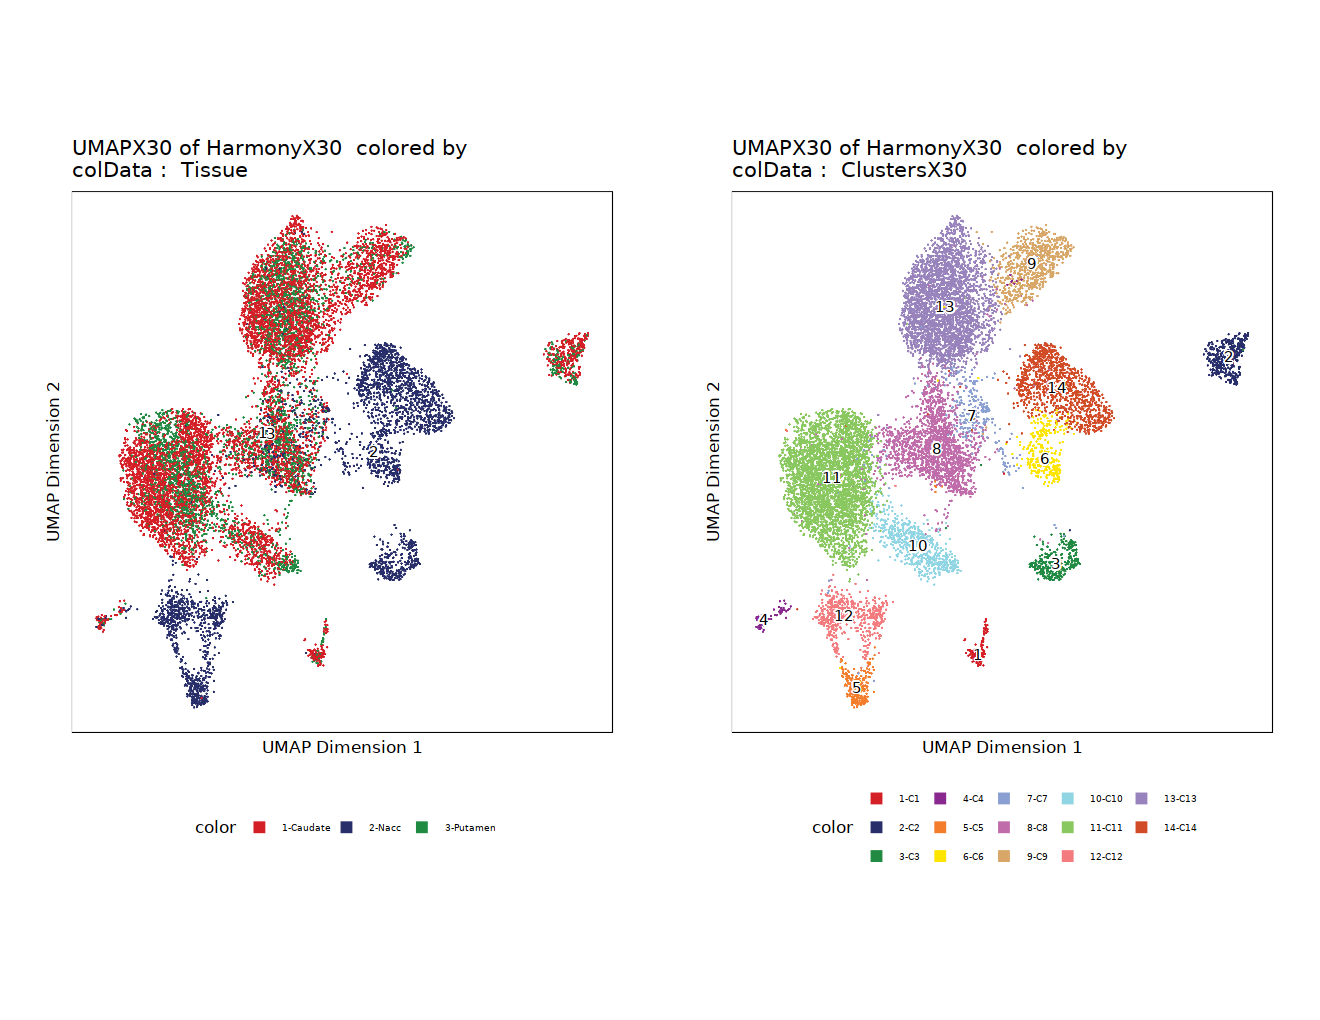

In [4]:
p1 <- plotEmbedding( proj, colorBy = "cellColData", name = "Tissue", embedding = "UMAPX30")
p3 <- plotEmbedding( proj, colorBy = "cellColData", name = "ClustersX30", embedding = "UMAPX30")

ggAlignPlots(p1, p3, type = "h")

In [5]:
idxSample <- BiocGenerics::which(proj$ClustersX30 %ni% c('C7','C8'))
cellsSample <- proj$cellNames[idxSample]
proj = proj[cellsSample, ]

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!



In [6]:
proj <- addImputeWeights(proj, reducedDims = "HarmonyX30")

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-5c82b5136780a-Date-2021-04-22_Time-00-21-49.log
If there is an issue, please report to github with logFile!

2021-04-22 00:21:49 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



# Integrate with snRNA-seq subclusters of MSNs

In [7]:
SETDIR='/projects/pfenninggroup/singleCell/Macaque_snATAC-seq'
rna_msn_fn = file.path(SETDIR, 'm015_Peanut/snRNAseq/rdas', 'bills_MSN_labeled.rds')
rna_msn_se = readRDS(rna_msn_fn)
rna_msn_se$cell_type <- Idents(rna_msn_se)

rna_msn_se = as.SingleCellExperiment(rna_msn_se)
head(colData(rna_msn_se))

##get the normalized counts matrix
counts(rna_msn_se) = 10^logcounts(rna_msn_se) - 1 
logcounts(rna_msn_se) = NULL

DataFrame with 6 rows and 13 columns
                    orig.ident nCount_RNA nFeature_RNA    celltype        tech
                   <character>  <numeric>    <integer> <character> <character>
AGGAATACATGGATCT-7       Penut      16032         4618       Penut       Penut
CAGCCAGGTGCCGAAA-7       Penut      14917         4573       Penut       Penut
CATGAGTAGCCTCATA-7       Penut      13046         4269       Penut       Penut
ACTGTGATCATGACAC-7       Penut      15644         4945       Penut       Penut
GCCCAGATCTGTCTCG-7       Penut      14437         4733       Penut       Penut
AGGGAGTTCCACACCT-1       Penut      11309         3770       Penut       Penut
                        region RNA_snn_res.0.5 seurat_clusters
                   <character>     <character>        <factor>
AGGAATACATGGATCT-7     Caudate               1               1
CAGCCAGGTGCCGAAA-7     Caudate               1               1
CATGAGTAGCCTCATA-7     Caudate               1               1
ACTGTGATCATGACAC

In [8]:
##################################
# split the cells in snATAC and snRNA by region
groupList <- SimpleList(
  Caudoputamen = SimpleList(
    ATAC = proj$cellNames[proj$Tissue %in% c('Caudate', 'Putamen')],
    RNA = colnames(rna_msn_se)[colData(rna_msn_se)$region %in% c('Caudate', 'Putamen')]
  ),
  Nacc = SimpleList(
    ATAC = proj$cellNames[proj$Tissue == 'Nacc'],
    RNA = colnames(rna_msn_se)[colData(rna_msn_se)$region == 'Nacc']
  )
)

In [9]:
#####################################
# integration split by tissue region
proj <- addGeneIntegrationMatrix(
    ArchRProj = proj,
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "HarmonyX30",
    seRNA = rna_msn_se,  nGenes = 2000, 
    addToArrow = FALSE, plotUMAP = TRUE,
    groupList = groupList,
    groupRNA = "cell_type",
    nameCell = "predictedCell_Co",
    nameGroup = "predictedGroup_Co",
    nameScore = "predictedScore_Co"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-5c82b3528fa2a-Date-2021-04-22_Time-00-22-39.log
If there is an issue, please report to github with logFile!

2021-04-22 00:22:39 : Running Seurat's Integration Stuart* et al 2019, 0.006 mins elapsed.

2021-04-22 00:22:41 : Checking ATAC Input, 0.038 mins elapsed.

2021-04-22 00:22:41 : Checking RNA Input, 0.038 mins elapsed.

2021-04-22 00:23:06 : Found 18013 overlapping gene names from gene scores and rna matrix!, 0.457 mins elapsed.

2021-04-22 00:23:06 : Creating Integration Blocks, 0.458 mins elapsed.

2021-04-22 00:23:06 : Prepping Interation Data, 0.458 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2021-04-22 00:23:09 : Computing Integration in 2 Integration Blocks!, 0 mins elapsed.

2021-04-22 00:28:45 : Block (1 of 2) : Plotting Joint UMAP, 5.591 mins elapsed.

2021-04-22 00:29:20 : Block (2 of 2) : Plotting Joint UMAP, 6.184 mins elapsed.

2021-04-22 00:29:49 : Completed Integration with RNA M

# Compare snATAC clusters w/ snRNA clusters

In [10]:
# # add clusters for Harmony w/ higher resolution
# proj <- addClusters( proj, reducedDims = 'HarmonyX30', 
#                      method = "Seurat", name = "ClustersX30", 
#                      filterBias = TRUE,resolution = 1, force = TRUE)


preClust          
 [1,] D1-Matrix/Core C13
 [2,] D1/D2-Hybrid   C2 
 [3,] D2-Striosome   C1 
 [4,] D2-Matrix/Core C11
 [5,] D1-Striosome   C9 
 [6,] D2-Striosome   C10
 [7,] D2-Shell       C5 
 [8,] D1-Shell       C14
 [9,] D1-Matrix/Core C4 
[10,] D2-Shell       C12
[11,] D2-Shell       C6 
[12,] D1-NUDAP       C3

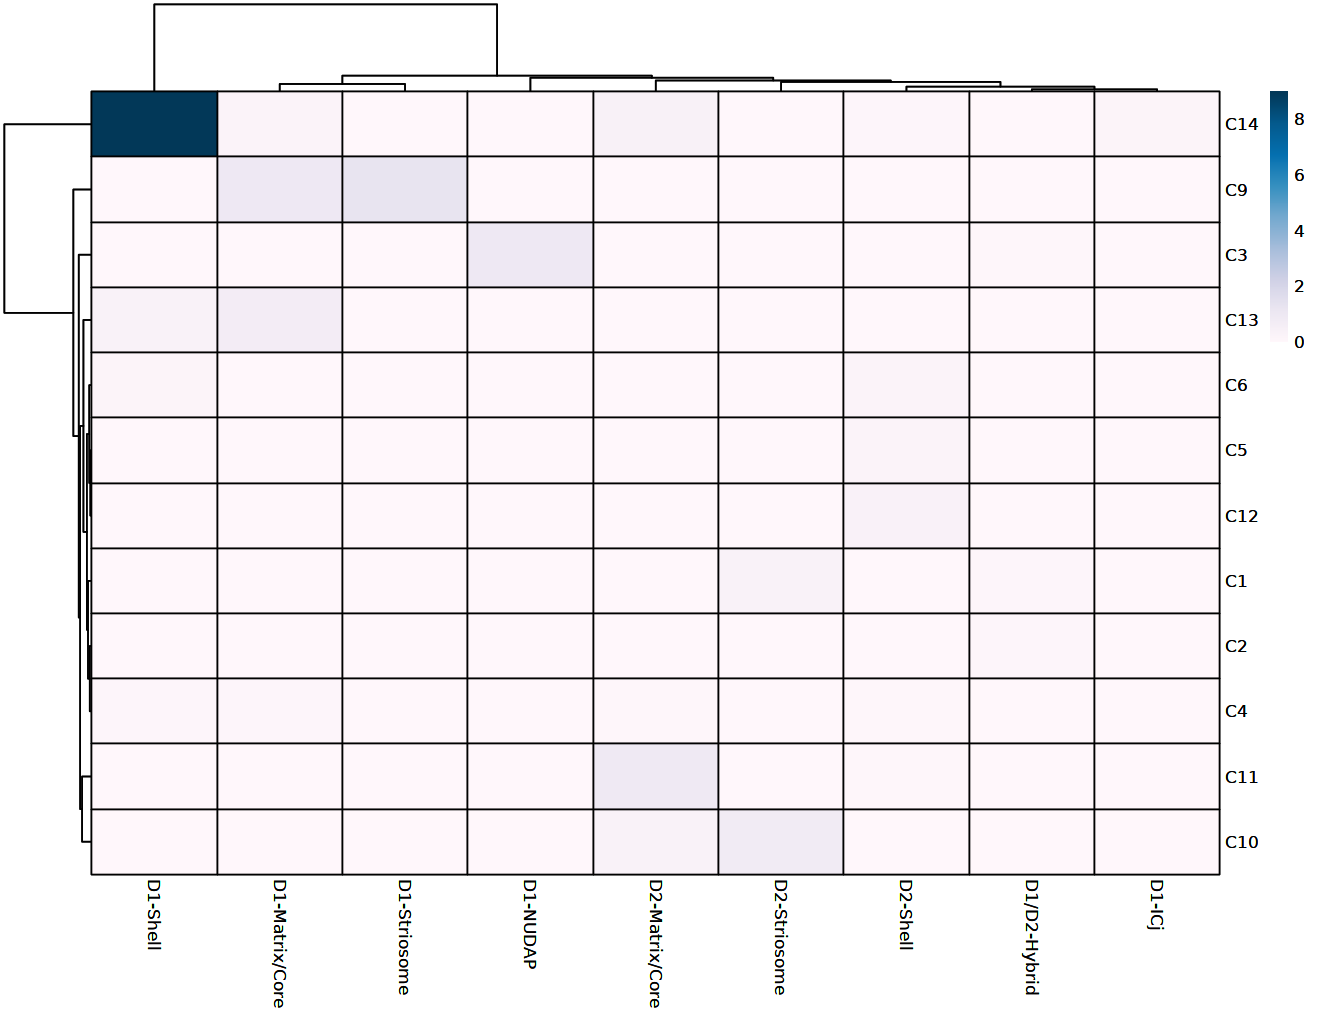

In [11]:
# plot the confusion matrix of cell types by predicted cell type clusters
cM <- confusionMatrix(paste0(proj$ClustersX30), paste0(proj$predictedGroup_Co))
cM <- cM / Matrix::colSums(cM)
p <- pheatmap::pheatmap(
  mat = as.matrix(cM), 
  color = paletteContinuous("whiteBlue"), 
  border_color = "black")
p

preClust <- colnames(cM)[apply(cM, 1 , which.max)]
cbind(preClust, rownames(cM)) #Assignments

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b73aee3e8-Date-2021-04-22_Time-00-29-49.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b73aee3e8-Date-2021-04-22_Time-00-29-49.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b15b15819-Date-2021-04-22_Time-00-29-50.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b15b15819-Date-2021-04-22_Time-00-29-50.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b707534cb-Date-2021-04-22_Time-00-29-51.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b707534cb-Date-2021-04-22_Ti

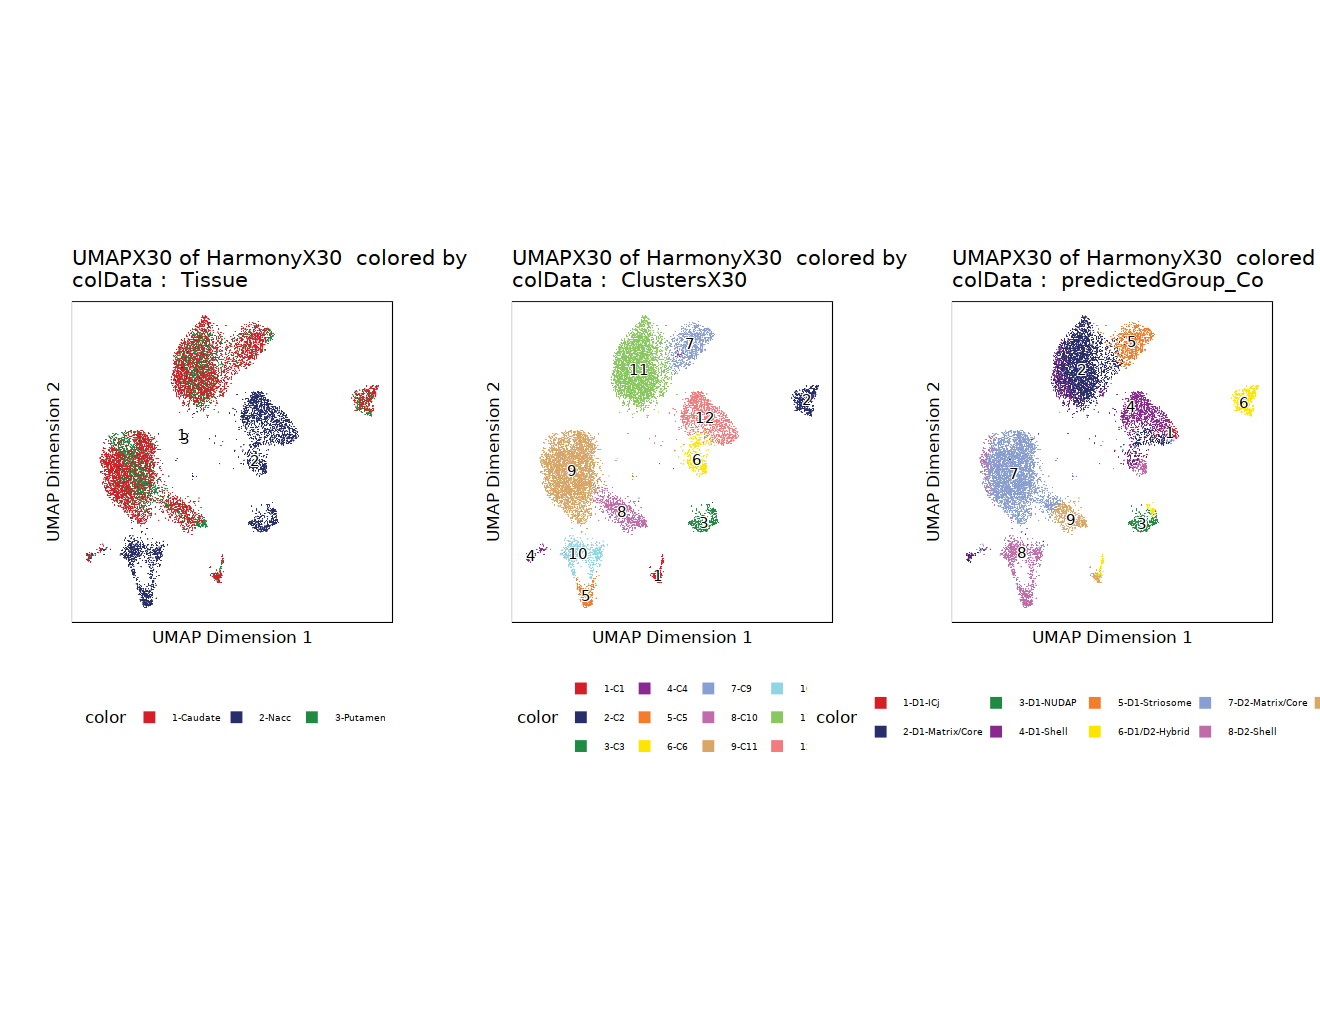

In [12]:
p1 <- plotEmbedding( proj, colorBy = "cellColData", name = "Tissue", embedding = "UMAPX30")
p2 <- plotEmbedding( proj, colorBy = "cellColData", name = "predictedGroup_Co", embedding = "UMAPX30")
p3 <- plotEmbedding( proj, colorBy = "cellColData", name = "ClustersX30", embedding = "UMAPX30")

ggAlignPlots(p1, p3, p2, type = "h")

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b4edf00e8-Date-2021-04-22_Time-00-29-56.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b4edf00e8-Date-2021-04-22_Time-00-29-56.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b5fc4dc20-Date-2021-04-22_Time-00-29-57.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b5fc4dc20-Date-2021-04-22_Time-00-29-57.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b3ccf3edf-Date-2021-04-22_Time-00-29-59.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b3ccf3edf-Date-2021-04-22_Ti

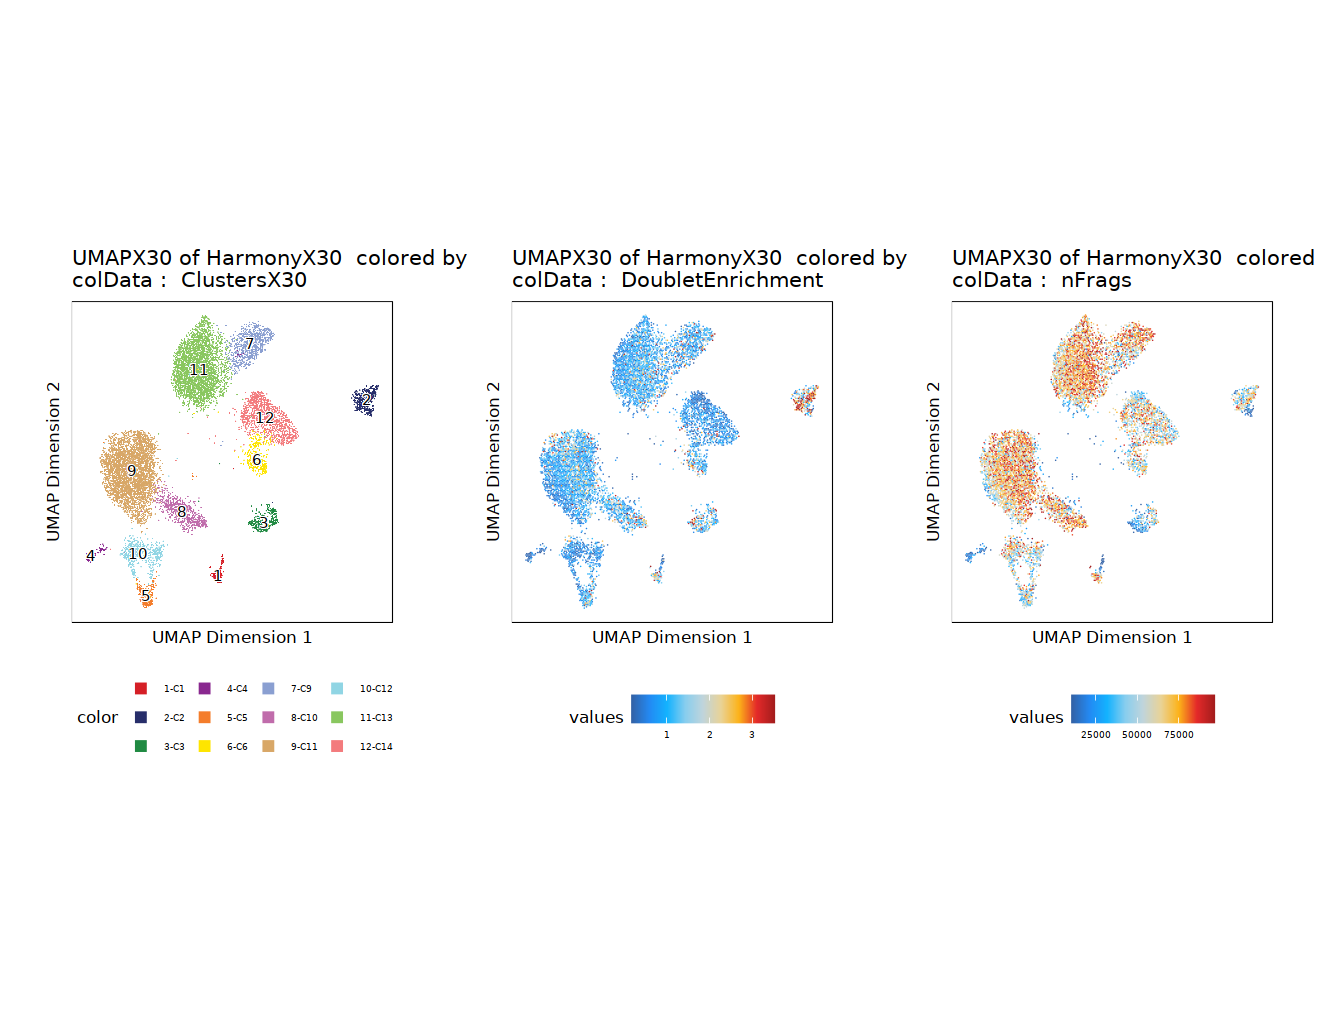

In [13]:
## make UMAP plots of
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "ClustersX30", embedding = "UMAPX30")

p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "DoubletEnrichment", embedding = "UMAPX30")

p3 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "nFrags", embedding = "UMAPX30")

ggAlignPlots(p1, p2, p3,type = "h")

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b76be762b-Date-2021-04-22_Time-00-30-02.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2021-04-22 00:30:03 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b76be762b-Date-2021-04-22_Time-00-30-02.log



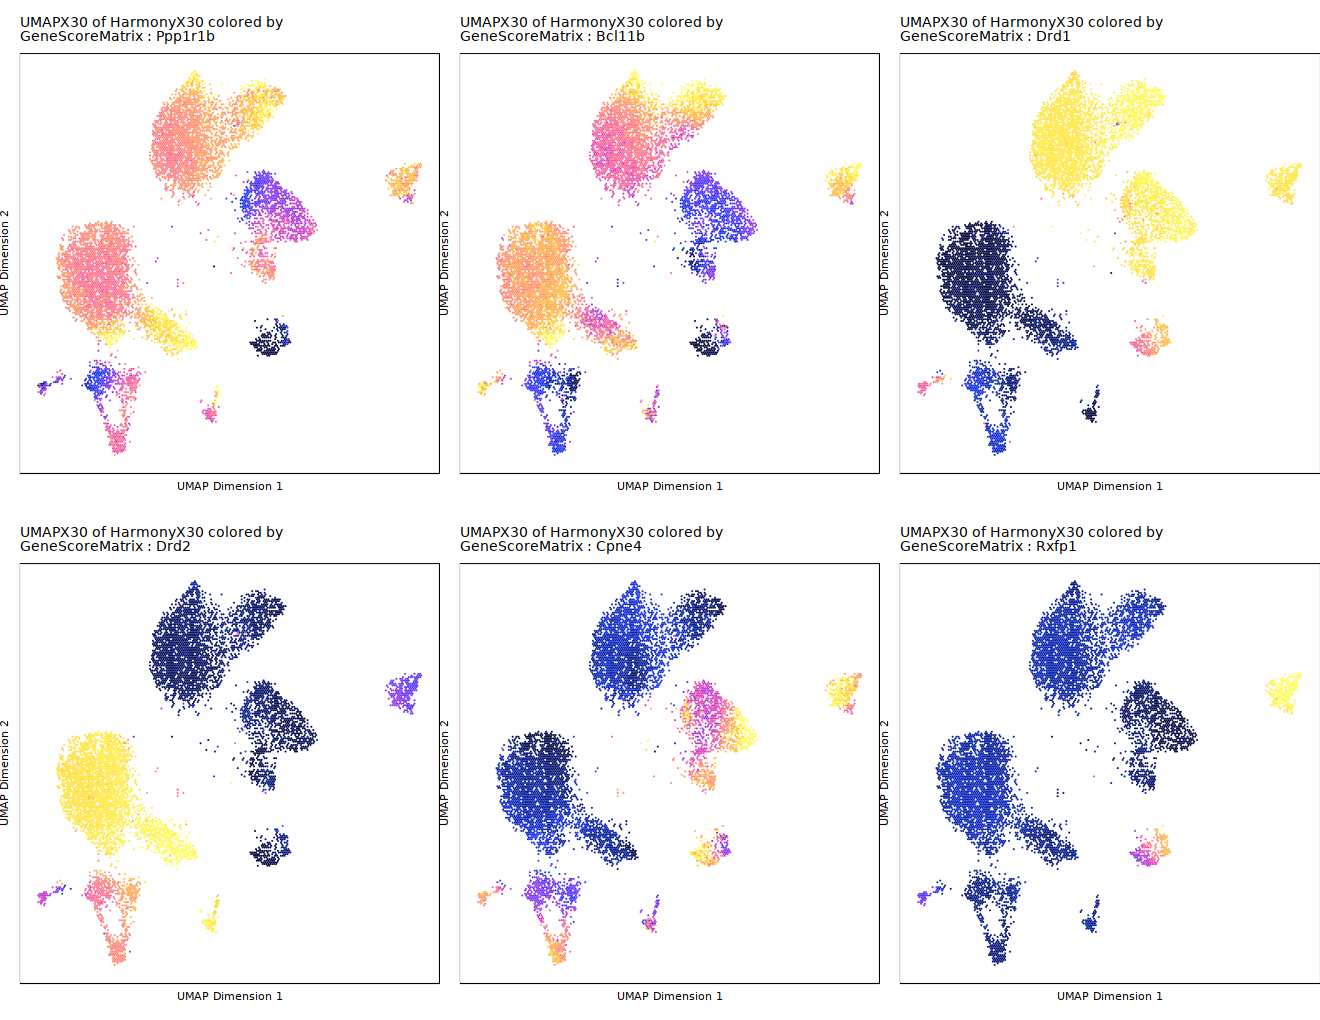

In [14]:
# Broad MSN marker, mouse 2010300C02Rik == human KIAA1211L
# MSN markers, Ppp1r1b = DARPP-32, Bcl11b=Ctip2
markMSN3 = c('Ppp1r1b', 'Bcl11b', 'Drd1','Drd2', 'Cpne4','Rxfp1')
p <- plotEmbedding( ArchRProj = proj, colorBy = "GeneScoreMatrix", 
                    name = markMSN3, embedding = "UMAPX30")
p3 <- lapply(p, function(x){
  x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) + theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(  axis.text.x=element_blank(),  axis.ticks.x=element_blank(), 
            axis.text.y=element_blank(),  axis.ticks.y=element_blank())
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p3))

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b65644ade-Date-2021-04-22_Time-00-30-25.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2021-04-22 00:30:26 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b65644ade-Date-2021-04-22_Time-00-30-25.log



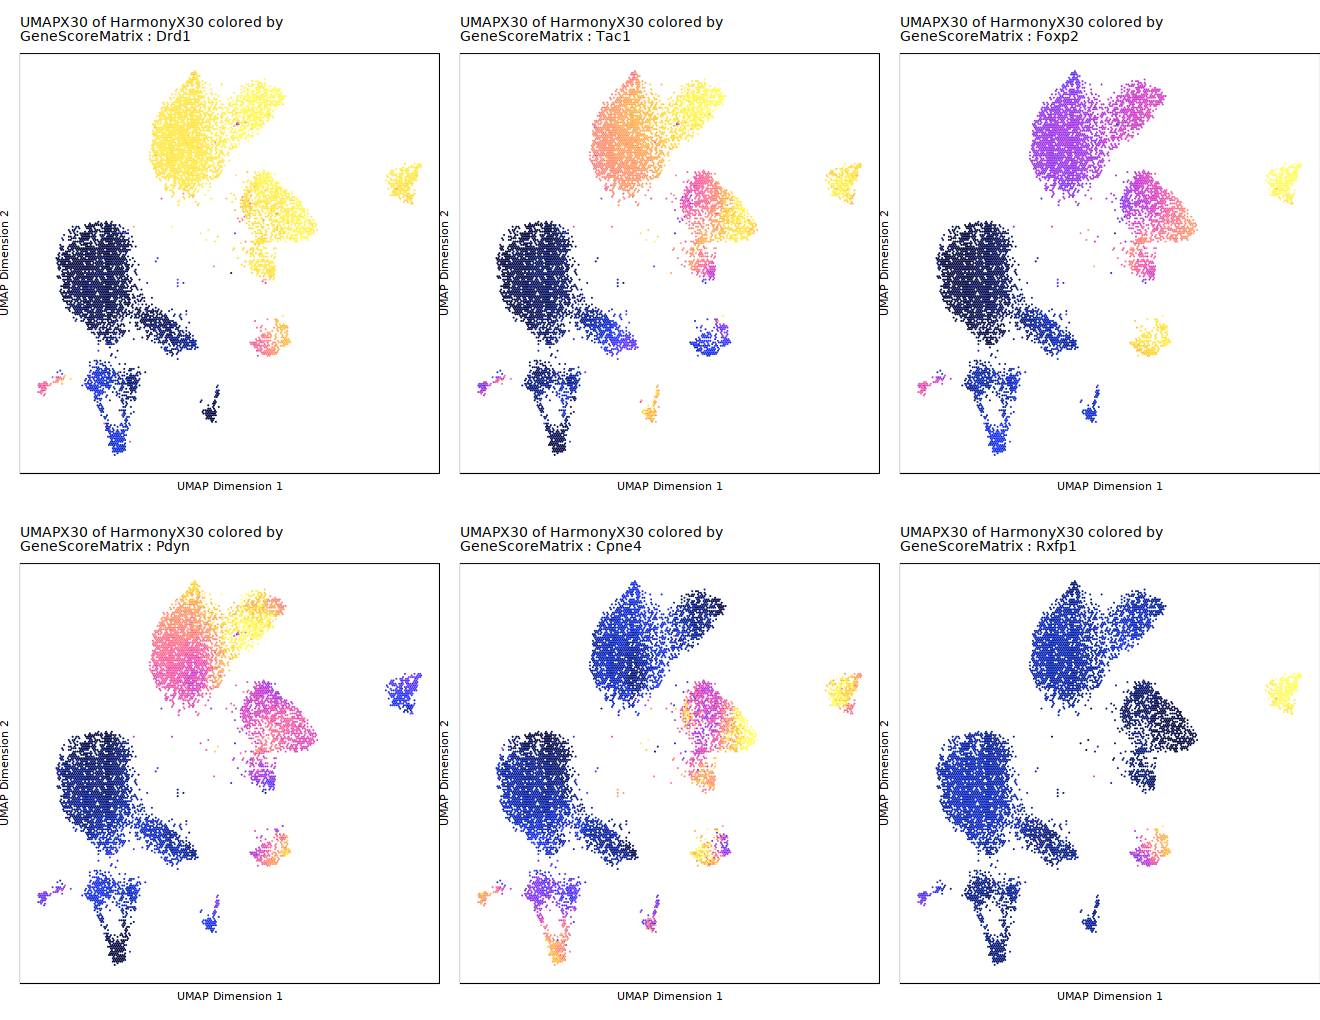

In [15]:
markMSN1 = c('Drd1','Tac1','Foxp2','Pdyn', 'Cpne4', 'Rxfp1') # D1 markers

# D1 MSN
p <- plotEmbedding( ArchRProj = proj, colorBy = "GeneScoreMatrix", 
                    name = markMSN1, embedding = "UMAPX30") # 
p1 <- lapply(p, function(x){
  x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme( axis.text.x=element_blank(),  axis.ticks.x=element_blank(), 
           axis.text.y=element_blank(),  axis.ticks.y=element_blank())
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p1))

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b62281e71-Date-2021-04-22_Time-00-30-44.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2021-04-22 00:30:45 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b62281e71-Date-2021-04-22_Time-00-30-44.log



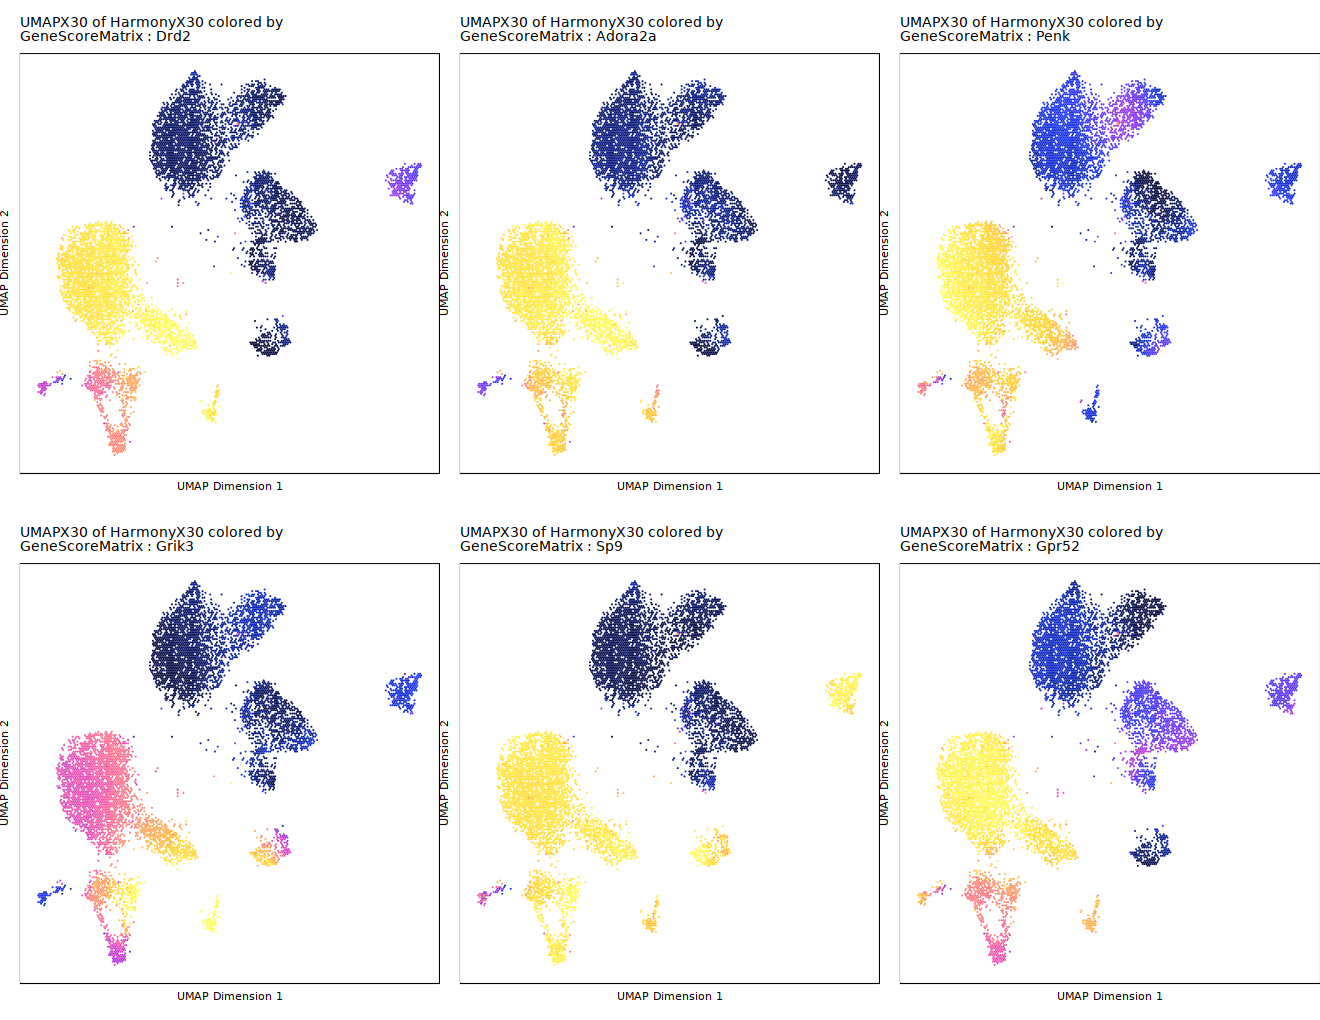

In [16]:
markMSN2 = c('Drd2','Adora2a','Penk', 'Grik3', 'Sp9', 'Gpr52')# D2 markers

# D2 MSN
p <- plotEmbedding( ArchRProj = proj, colorBy = "GeneScoreMatrix", 
                    name = markMSN2, embedding = "UMAPX30")
p2 <- lapply(p, function(x){
  x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) + theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(  axis.text.x=element_blank(),  axis.ticks.x=element_blank(), 
            axis.text.y=element_blank(),  axis.ticks.y=element_blank())
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))


Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b5929dfb-Date-2021-04-22_Time-00-31-03.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2021-04-22 00:31:04 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b5929dfb-Date-2021-04-22_Time-00-31-03.log



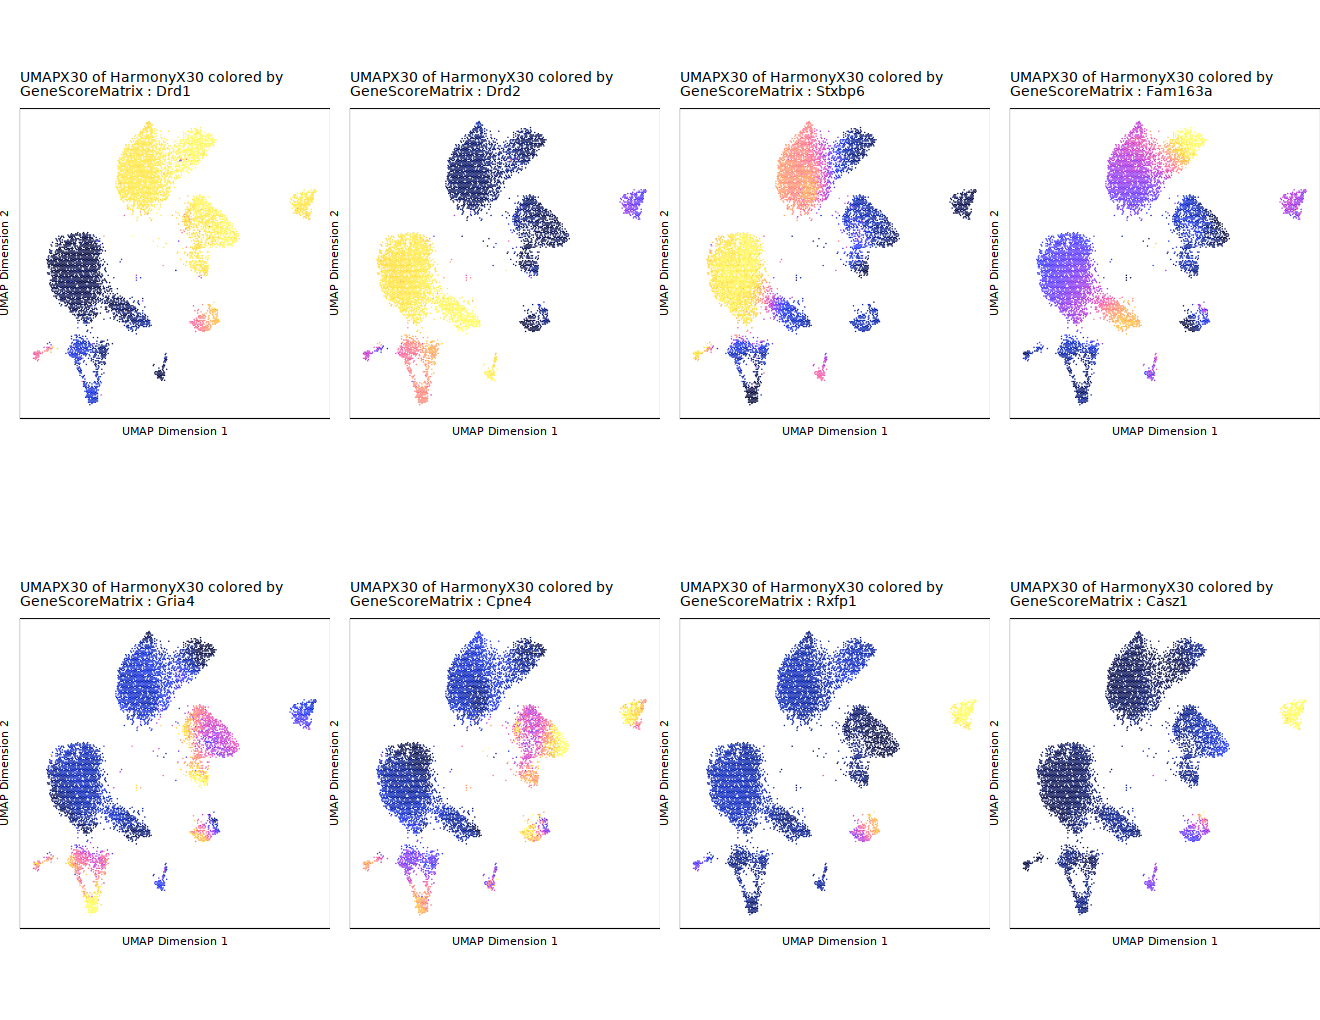

In [17]:
markFig1 = c('Drd1', 'Drd2', 'Stxbp6', 'Fam163a', 'Gria4', 'Cpne4', 'Rxfp1', 'Casz1')

# D2 MSN
p <- plotEmbedding( ArchRProj = proj, colorBy = "GeneScoreMatrix", 
                    name = markFig1, embedding = "UMAPX30")
p2 <- lapply(p, function(x){
  x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) + theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(  axis.text.x=element_blank(),  axis.ticks.x=element_blank(), 
            axis.text.y=element_blank(),  axis.ticks.y=element_blank())
})
do.call(cowplot::plot_grid, c(list(nrow = 2),p2))



# Finalize the clusters
- add the pseudo snRNA profiles to the cell types

In [18]:
#####################################
# integration split by tissue region
proj <- addGeneIntegrationMatrix(
    ArchRProj = proj,
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "HarmonyX30",
    seRNA = rna_msn_se,  nGenes = 2000, 
    addToArrow = TRUE, plotUMAP = TRUE,
    groupList = groupList,
    groupRNA = "cell_type",
    nameCell = "predictedCell_Co",
    nameGroup = "predictedGroup_Co",
    nameScore = "predictedScore_Co", 
    force = TRUE
)
proj = saveArchRProject(ArchRProj = proj)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-5c82b41b267fb-Date-2021-04-22_Time-00-37-34.log
If there is an issue, please report to github with logFile!

2021-04-22 00:37:34 : Running Seurat's Integration Stuart* et al 2019, 0.004 mins elapsed.

2021-04-22 00:37:36 : Checking ATAC Input, 0.04 mins elapsed.

2021-04-22 00:37:36 : Checking RNA Input, 0.041 mins elapsed.

2021-04-22 00:38:03 : Found 18013 overlapping gene names from gene scores and rna matrix!, 0.483 mins elapsed.

2021-04-22 00:38:03 : Creating Integration Blocks, 0.483 mins elapsed.

2021-04-22 00:38:03 : Prepping Interation Data, 0.484 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2021-04-22 00:38:06 : Computing Integration in 2 Integration Blocks!, 0 mins elapsed.

2021-04-22 00:45:26 : Block (1 of 2) : Plotting Joint UMAP, 7.324 mins elapsed.

2021-04-22 00:46:01 : Block (2 of 2) : Plotting Joint UMAP, 7.92 mins elapsed.

2021-04-22 00:46:29 : Transferring Data to ArrowFiles, 8

In [19]:
# plot the confusion matrix of cell types by predicted cell type clusters
cM <- confusionMatrix(paste0(proj$ClustersX30), paste0(proj$predictedGroup_Co))
cM <- cM / Matrix::colSums(cM)
preClust <- colnames(cM)[apply(cM, 1 , which.max)]
tmp = cbind( rownames(cM), preClust) #Assignments
tmp[order(tmp[,2]),]

preClust      
 [1,] C13 D1-Matrix/Core
 [2,] C4  D1-Matrix/Core
 [3,] C3  D1-NUDAP      
 [4,] C14 D1-Shell      
 [5,] C9  D1-Striosome  
 [6,] C2  D1/D2-Hybrid  
 [7,] C11 D2-Matrix/Core
 [8,] C5  D2-Shell      
 [9,] C12 D2-Shell      
[10,] C6  D2-Shell      
[11,] C1  D2-Striosome  
[12,] C10 D2-Striosome

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b5329f5f4-Date-2021-04-22_Time-00-55-27.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b5329f5f4-Date-2021-04-22_Time-00-55-27.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b24ffb485-Date-2021-04-22_Time-00-55-28.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b24ffb485-Date-2021-04-22_Time-00-55-28.log



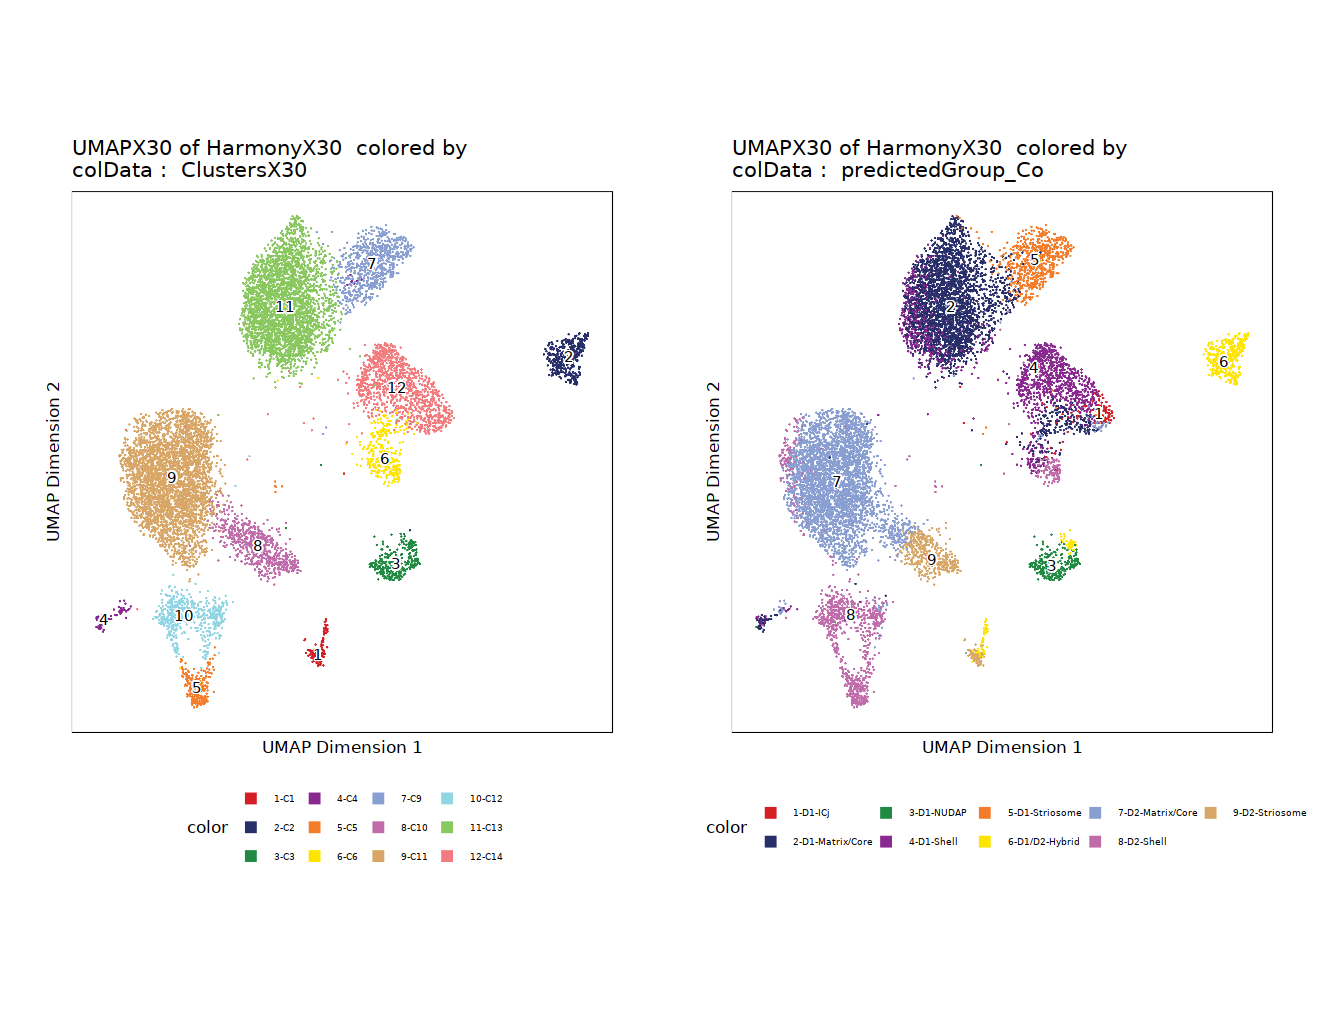

In [20]:
p2 <- plotEmbedding( proj, colorBy = "cellColData", name = "predictedGroup_Co", embedding = "UMAPX30")
p3 <- plotEmbedding( proj, colorBy = "cellColData", name = "ClustersX30", embedding = "UMAPX30")

ggAlignPlots(p3, p2,  type = "h")

# Relabel cluster and call peaks

In [23]:
############################################
# using marker gene scores, give cluster names
remapClust = c(
  'C1'  = 'D2.Grik3', # D2 subcluster marked by Grik3, Sp9
  'C2'  = 'D1.Hybrid',
  'C3'  = 'D1.NUDAP',
  'C4'  = 'D2.Penk', # D2 subcluster marked by Penk
  'C5'  = 'D2.Shell',
  'C6'  = 'D1.Shell',
  'C9'  = 'D1.Striosome',
  'C10' = 'D2.Striosome',
  'C11' = 'D2.Matrix',
  'C12' = 'D2.Core',
  'C13' = 'D1.Matrix',
  'C14' = 'D1.Core'
)

proj$Clusters = mapLabels(proj$ClustersX30, newLabels = remapClust, oldLabels = names(remapClust))
table(proj$Clusters)


     D1.Core    D1.Hybrid    D1.Matrix     D1.NUDAP     D1.Shell D1.Striosome 
        1115          394         3205          294          323          726 
     D2.Core     D2.Grik3    D2.Matrix      D2.Penk     D2.Shell D2.Striosome 
         564          142         3651          106          248          644 

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b44961c89-Date-2021-04-22_Time-00-57-49.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b44961c89-Date-2021-04-22_Time-00-57-49.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-5c82b7d3ba8e1-Date-2021-04-22_Time-00-57-51.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-5c82b7d3ba8e1-Date-2021-04-22_Time-00-57-51.log



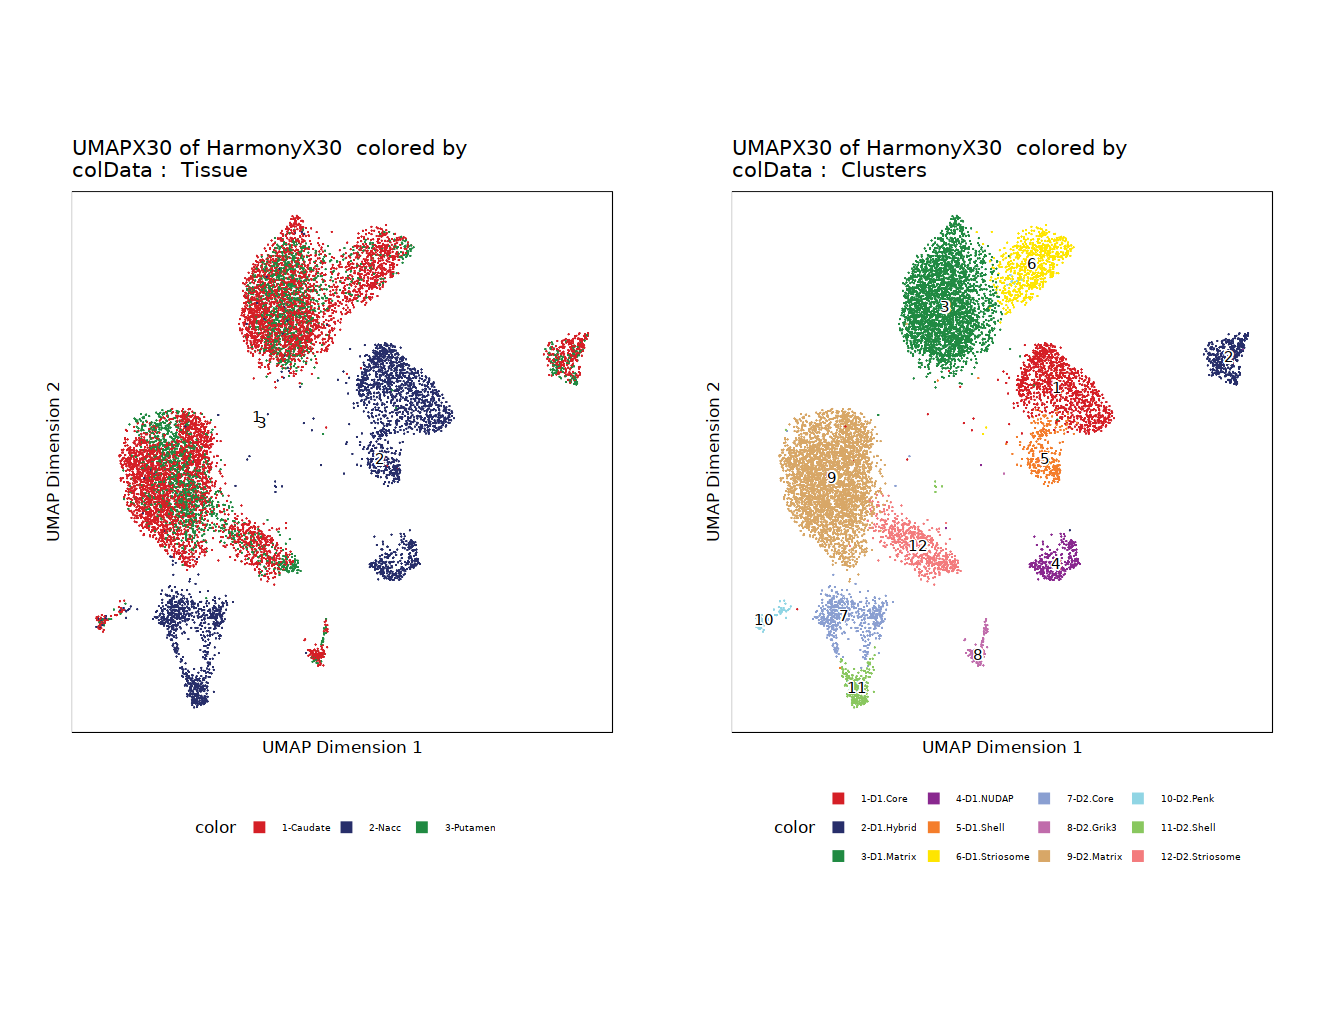

In [24]:
## make UMAP plots
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "Tissue", embedding = "UMAPX30")

p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "Clusters", embedding = "UMAPX30")


ggAlignPlots(p1, p2,  type = "h")

In [25]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

In [26]:
# make group coverage, call peaks, and 
proj<-addGroupCoverages(proj, groupBy="Clusters", force = TRUE)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-5c82b1fb65739-Date-2021-04-22_Time-01-00-59.log
If there is an issue, please report to github with logFile!

D1.Core (1 of 12) : CellGroups N = 4

D1.Hybrid (2 of 12) : CellGroups N = 5

D1.Matrix (3 of 12) : CellGroups N = 5

D1.NUDAP (4 of 12) : CellGroups N = 4

D1.Shell (5 of 12) : CellGroups N = 4

D1.Striosome (6 of 12) : CellGroups N = 5

D2.Core (7 of 12) : CellGroups N = 4

D2.Grik3 (8 of 12) : CellGroups N = 2

D2.Matrix (9 of 12) : CellGroups N = 5

D2.Penk (10 of 12) : CellGroups N = 2

D2.Shell (11 of 12) : CellGroups N = 4

D2.Striosome (12 of 12) : CellGroups N = 5

2021-04-22 01:01:01 : Further Sampled 10 Groups above the Max Fragments!, 0.034 mins elapsed.

2021-04-22 01:01:05 : Creating Coverage Files!, 0.088 mins elapsed.

2021-04-22 01:01:05 : Batch Execution w/ safelapply!, 0.088 mins elapsed.

2021-04-22 01:28:52 : Adding Kmer Bias to Coverage Files!, 27.88 mins elapsed.

Completed Kmer Bias Calculation

Adding 

In [28]:
# call peaks 
proj<-addReproduciblePeakSet(proj, groupBy = "Clusters", plot = FALSE, genomeSize = 2.7e9)

Searching For MACS2..

Found with $path!

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-5c82b2061c26a-Date-2021-04-22_Time-01-58-23.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2021-04-22 01:58:24 : Peak Calling Parameters!, 0.012 mins elapsed.



                    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
D1.Core           D1.Core   1115       1111           4  234  317   150000
D1.Hybrid       D1.Hybrid    394        351           5   57   82   150000
D1.Matrix       D1.Matrix   3205       2271           5  378  500   150000
D1.NUDAP         D1.NUDAP    294        292           4   68   78   146000
D1.Shell         D1.Shell    323        320           4   74   87   150000
D1.Striosome D1.Striosome    726        664           5   65  185   150000
D2.Core           D2.Core    564        562           4  121  151   150000
D2.Grik3         D2.Grik3    142        142           2   71   71    71000
D2.Matrix       D2.Matrix   3651       2387           5  399  500   150000
D2.Penk           D2.Penk    106        106           2   53   53    53000
D2.Shell         D2.Shell    248        246           4   49   69   123000
D2.Striosome D2.Striosome    644        503           5   75  133   150000


2021-04-22 01:58:24 : Batching Peak Calls!, 0.012 mins elapsed.

2021-04-22 01:58:24 : Batch Execution w/ safelapply!, 0 mins elapsed.

2021-04-22 04:35:39 : Identifying Reproducible Peaks!, 157.275 mins elapsed.

2021-04-22 04:38:10 : Creating Union Peak Set!, 159.779 mins elapsed.

Converged after 11 iterations!

2021-04-22 04:38:17 : Finished Creating Union Peak Set (296239)!, 159.909 mins elapsed.



In [29]:
# add peak counts matrix 
proj <- addPeakMatrix(proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-5c82b1aab67b5-Date-2021-04-22_Time-04-38-17.log
If there is an issue, please report to github with logFile!

2021-04-22 04:38:18 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-5c82b1aab67b5-Date-2021-04-22_Time-04-38-17.log



In [30]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

In [32]:
# add motif enrichment matrix
proj <- addMotifAnnotations(ArchRProj = proj, motifSet = "JASPAR2018", name = "Motif")

ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-5c82b43a467a5-Date-2021-04-22_Time-08-08-23.log
If there is an issue, please report to github with logFile!

2021-04-22 08:08:24 : Gettting Motif Set, Species : , 0.005 mins elapsed.

2021-04-22 08:08:51 : Finding Motif Positions with motifmatchr!, 0.451 mins elapsed.

2021-04-22 08:21:41 : Creating Motif Overlap Matrix, 13.288 mins elapsed.

2021-04-22 08:21:51 : Finished Getting Motif Info!, 13.465 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addMotifAnnotations-5c82b43a467a5-Date-2021-04-22_Time-08-08-23.log



In [33]:
# add motif deviations matrix
proj <- addBgdPeaks(proj)
proj <- addDeviationsMatrix(proj,  peakAnnotation = "Motif", force = TRUE)

Identifying Background Peaks!

Using Previous Background Peaks!

ArchR logging to : ArchRLogs/ArchR-addDeviationsMatrix-5c82b64486241-Date-2021-04-22_Time-08-22-41.log
If there is an issue, please report to github with logFile!



NULL


2021-04-22 08:22:52 : Batch Execution w/ safelapply!, 0 mins elapsed.

Warning message in mccollect(jobs):
“3 parallel jobs did not deliver results”
###########
2021-04-22 14:00:40 : Completed Computing Deviations!, 337.984 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-addDeviationsMatrix-5c82b64486241-Date-2021-04-22_Time-08-22-41.log



In [34]:
# add co-accessibility matrix
proj <- addCoAccessibility(proj, reducedDims = "HarmonyX30", dimsToUse = 1:30,
                           scaleDims = TRUE, corCutOff = 0.75, k = 100, 
                           knnIteration = 500, overlapCutoff = 0.8, 
                           maxDist = 1e+05, scaleTo = 10^4, log2Norm = TRUE)

ArchR logging to : ArchRLogs/ArchR-addCoAccessibility-5c82b64fc1374-Date-2021-04-22_Time-14-00-42.log
If there is an issue, please report to github with logFile!

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2021-04-22 14:00:42 : Computing KNN, 0.011 mins elapsed.

2021-04-22 14:00:43 : Identifying Non-Overlapping KNN pairs, 0.015 mins elapsed.

2021-04-22 14:00:45 : Identified 481 Groupings!, 0.055 mins elapsed.

2021-04-22 14:01:06 : Computing Co-Accessibility chr1 (1 of 21), 0.415 mins elapsed.

2021-04-22 14:01:40 : Computing Co-Accessibility chr2 (2 of 21), 0.979 mins elapsed.

2021-04-22 14:02:04 : Computing Co-Accessibility chr3 (3 of 21), 1.366 mins elapsed.

2021-04-22 14:02:27 : Computing Co-Accessibility chr4 (4 of 21), 1.763 mins elapsed.

2021-04-22 14:02:48 : Computing Co-Accessibility chr5 (5 of 21), 2.104 mins elapsed.

2021-04-22 14:03:39 : Computing Co-Accessibility chr6 (6 of 21), 2.952 mins elapsed.

2021-04-22 14:04:29 : Computing Co-Accessibility chr7 (

In [35]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

In [36]:
proj <- addPeak2GeneLinks(
    ArchRProj = proj,
    reducedDims = "HarmonyX30"
)
proj = saveArchRProject(ArchRProj = proj)

ArchR logging to : ArchRLogs/ArchR-addPeak2GeneLinks-5c82b18c50aa-Date-2021-04-22_Time-14-12-06.log
If there is an issue, please report to github with logFile!

2021-04-22 14:12:07 : Getting Available Matrices, 0.016 mins elapsed.

2021-04-22 14:12:32 : Filtered Low Prediction Score Cells (227 of 11412, 0.02), 0.075 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2021-04-22 14:12:39 : Computing KNN, 0.181 mins elapsed.

2021-04-22 14:12:39 : Identifying Non-Overlapping KNN pairs, 0.187 mins elapsed.

2021-04-22 14:12:41 : Identified 481 Groupings!, 0.228 mins elapsed.

2021-04-22 14:12:42 : Getting Group RNA Matrix, 0.229 mins elapsed.

2021-04-22 14:16:35 : Getting Group ATAC Matrix, 4.116 mins elapsed.

2021-04-22 14:24:11 : Normalizing Group Matrices, 11.714 mins elapsed.

2021-04-22 14:24:22 : Finding Peak Gene Pairings, 11.905 mins elapsed.

2021-04-22 14:24:23 : Computing Correlations, 11.915 mins elapsed.

2021-04-22 14:24:46 : Completed Peak2Gene Correlat